# midinet_doubleモデルの学習
midinet2をベースに2小節を1まとまりとしたメロディを生成  
セクションベクトルはない

In [1]:
import os, glob, time, ipdb, pickle, numpy as np
visible_devices = [3]
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in visible_devices])

import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from PIL import Image
from multi_gpu import MultiGPUWrapper
from utils import Timer, get_model, count_params
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_dir = "../datasets/theorytab/midinet"
output_dir = f"{base_dir}/learning"

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

## DataLoaderの作成

In [3]:
class MidinetDataloader():
    def __init__(self, data_path, pitch_range=[0, 64], show_shape=False):
        data = pickle.load(open(data_path,'rb'))
        
        melody, prev, chord = [], [], []
        for m, p, c in data:
            melody.append(m)
            prev.append(p)
            chord.append(c)
        
        self.size = len(melody)
        steps = len(melody[0])
        bottom, top = pitch_range
        
        melody = np.array(melody)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        prev = np.array(prev)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        chord = np.array(chord)
        
        if show_shape:
            print("melody shape", melody.shape)
            print("prev shape", prev.shape)
            print("condition shape", chord.shape)
        
        self.x = torch.from_numpy(melody).float()
        self.prev_x   = torch.from_numpy(prev).float()
        self.y  = torch.from_numpy(chord).float()

    def __getitem__(self, index):
        return self.x[index], self.prev_x[index], self.y[index]

    def __len__(self):
        return self.size

In [4]:
def get_dataloader(data_path, batch_size=72, shuffle=True):
    iterator = MidinetDataloader(data_path)
    kwargs = {'num_workers': 4, 'pin_memory': True}
    data_loader = DataLoader(iterator, batch_size=batch_size, shuffle=shuffle, **kwargs)
    print('Data loading is completed.')
    print(f'{len(data_loader)} batches from {len(iterator)} bars are obtained.')
    return data_loader

動作確認

In [5]:
input_data_path = os.path.join(base_dir, "midinet_double.pkl")
dataloader = get_dataloader(input_data_path, batch_size=100)

Data loading is completed.
557 batches from 55617 bars are obtained.


In [10]:
batch = next(dataloader.__iter__())
batch[0].shape # melody

torch.Size([100, 1, 96, 64])

## Modelの作成

#### model用共通関数の作成

In [5]:
def concat_vector(x, y):
    x_0, _, x_2, x_3 = x.shape
    y2 = y.expand(x_0, y.shape[1], x_2, x_3)
    return torch.cat((x, y2),1)
    
def batch_norm(x, eps=1e-05, momentum=0.9, affine=True):
    device = x.device
    if x.ndim == 3:
        return nn.BatchNorm1d(x.shape[1], eps=eps, momentum=momentum, affine=affine).to(device)(x)
    elif x.ndim == 4:
        return nn.BatchNorm2d(x.shape[1], eps=eps, momentum=momentum, affine=affine).to(device)(x)
    else:
        return x

def lrelu(x, leak=0.2):
    z = torch.mul(x,leak)
    return torch.max(x, z)

#### Generator
ここからが本題.モデルの入力を変えたい  

forwardの入力
- z (batch, noise_size) = (72, 100): ランダムノイズ
- prev_x (batch, ch, steps, pitch) = (72, 1, 96, 64): 前のブロック
- condition (batch, 96)

forwardの出力
- g_x (batch, ch, steps, pitch)= (72, 1, 96, 64): 生成された今の小節

畳み込みをさらに1段階増やす  
おそらく三連譜が出てくるのは1/12分音符として使われるのが一般的だろうと踏んで，24->8のところでカーネルサイズを変更  
prev_x -> ピッチ畳み込み -> 96 -> 48 -> 24 -> 8 -> 4 -> 2 -> 1  

In [6]:
class SelfAttention(nn.Module):
    """ Self Attention Layer """
    
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        
        # Self Attention の学習に使用する層を定義
        
        # pointwise convolutionによる特徴量変換，圧縮
        # Attention Mapに使われるxは3つあり，それぞれに対して適用
        # これが非常に大きなカーネルを設定するよりも高速になるらしい
        self.query_conv = nn.Conv2d(in_dim, in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        
        # Attention Map 作成時の規格化用Softmax
        self.softmax = nn.Softmax(dim=-2)
        
        # Attention Mapにかける係数
        self.gamma = nn.Parameter(torch.zeros(1))
        
        
    def forward(self, x, get_map=False):
        
        # (B, C', W, H) -> (B, C', N)
        proj_query = self.query_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3])
        
        # 転置 x^t
        proj_query = proj_query.permute(0, 2, 1)
        
        # 転置してない方の x
        proj_key = self.key_conv(x).view(x.shape[0], -1, x.shape[2] * x.shape[3]) # (B, C', N)
        
        # バッチごとに行列の掛け算 x^t x を行う
        S = torch.bmm(proj_query, proj_key)
        
        # 規格化と転置を行い，Attention Mapを作成
        attention_map_T = self.softmax(S)
        attention_map = attention_map_T.permute(0, 2, 1)
        
        # xに対応する調整量 o を取得
        proj_value = self.value_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3]) # (B, C', N)
        o = torch.bmm(proj_value, attention_map.permute(0, 2, 1))
        
        # x + gamma o　を返す
        o = o.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3])
        out = x + self.gamma * o
        
        if get_map:
            return out, attention_map
        else:
            return out

# from torchgan SelfAttention2d
class SelfAttention(nn.Module):
    def __init__(self, input_dims, return_attn=False):
        super(SelfAttention2d, self).__init__()
        self.query = nn.Conv2d(input_dims, input_dims//8, 1)
        self.key = nn.Conv2d(input_dims, input_dims//8, 1)
        self.value = nn.Conv2d(input_dims, input_dims, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x, return_attn = return_attn):
        dims = (x.size(0), -1, x.size(2) * x.size(3))
        out_query = self.query(x).view(dims)
        out_key = self.key(x).view(dims).permute(0, 2, 1)
        attn = F.softmax(torch.bmm(out_key, out_query), dim=-1)
        out_value = self.value(x).view(dims)
        out_value = torch.bmm(out_value, attn).view(x.size())
        out = self.gamma * out_value + x
        if return_attn:
            return out, attn
        return out

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, pitch_range=64):
        super(Generator, self).__init__()
        self.bars = 2
        self.z_dim   = z_dim
        self.y_dim   = 48 * self.bars
        self.prev_ch = 16 * self.bars
        self.gf_dim  = 128
        self.gfc_dim = 1024

        self.h1      = nn.ConvTranspose2d(self.gf_dim+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h2      = nn.ConvTranspose2d(pitch_range+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h3      = nn.ConvTranspose2d(pitch_range+self.prev_ch, pitch_range, kernel_size=(3,1), stride=(3,1))
        self.h4      = nn.ConvTranspose2d(pitch_range+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h5      = nn.ConvTranspose2d(pitch_range+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h6      = nn.ConvTranspose2d(pitch_range+self.prev_ch, 1, kernel_size=(1,pitch_range), stride=(1,1))
        
        self.h0_prev = nn.Conv2d(1, self.prev_ch, kernel_size=(1,pitch_range), stride=(1,1))
        self.h1_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(2,1), stride=(2,1))
        self.h2_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(2,1), stride=(2,1))
        self.h3_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(3,1), stride=(3,1))
        self.h4_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(2,1), stride=(2,1))
        self.h5_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(2,1), stride=(2,1))
        
        self.sa2 = SelfAttention(pitch_range+self.prev_ch)
        self.sa4 = SelfAttention(pitch_range+self.prev_ch)

        self.linear1 = nn.Linear(self.z_dim + self.y_dim, self.gfc_dim)
        self.linear2 = nn.Linear(self.gfc_dim, self.gf_dim*2*1)

    def forward(self, z, prev_x, y):
        
        batch_size = len(z)
        
        h0_prev = lrelu(self.h0_prev(prev_x))   # 72, 32, 96, 1 ピッチ方向の畳み込み
        h1_prev = lrelu(self.h1_prev(h0_prev))  # 72, 32, 48, 1
        h2_prev = lrelu(self.h2_prev(h1_prev))  # 72, 32, 24, 1
        h3_prev = lrelu(self.h3_prev(h2_prev))  # 72, 32, 8, 1
        h4_prev = lrelu(self.h4_prev(h3_prev))  # 72, 32, 4, 1
        h5_prev = lrelu(self.h5_prev(h4_prev))  # 72, 32, 2, 1

        z = torch.cat((z,y),1)                          # 72, 196

        h0 = F.relu(self.linear1(z))                    # 72, 1024
        h1 = F.relu(self.linear2(h0))                   # 72, 256
        h1 = h1.view(batch_size, self.gf_dim, 2, 1)     # 72, 128, 2, 1
        
        h1 = concat_vector(h1, h5_prev)                 # 72, 160, 2, 1

        h2 = F.relu(self.h1(h1))                        # 72, 64, 4, 1 逆畳み込み． チャンネル数は固定で，3次元目が拡大される
        h2 = concat_vector(h2, h4_prev)                 # 72, 96, 4, 1
        h2 = self.sa2(h2)

        h3 = F.relu(self.h2(h2))                        # 72, 64, 8, 1 
        h3 = concat_vector(h3, h3_prev)                 # 72, 96, 8, 1

        h4 = F.relu(self.h3(h3))                        # 72, 64, 24, 1
        h4 = concat_vector(h4, h2_prev)                 # 72, 96, 24, 1
        h4 = self.sa4(h4)
        
        h5 = F.relu(self.h4(h4))                        # 72, 64, 48, 1
        h5 = concat_vector(h5, h1_prev)                 # 72, 96, 48, 1
        
        h6 = F.relu(self.h5(h5))                        # 72, 64, 96, 1
        h6 = concat_vector(h6, h0_prev)                 # 72, 96, 96, 1

        g_x = torch.sigmoid(self.h6(h6))                # 72, 1, 96, 64  ピッチ方向の逆畳み込み

        return g_x

動作確認

In [10]:
batch = next(dataloader.__iter__())
z = torch.randn(len(batch[0]), 100)

In [11]:
G = Generator()
print(count_params(G))
with Timer():
    g_out = G(z, batch[1], batch[2])
print(g_out.shape)

583155
Timer: 2.028108
torch.Size([100, 1, 96, 64])


#### Discriminator
forwardの入力
- x (batch, 1, steps, pitch) = (72, 1, 96, 64): real/fake判定を行う小節データ
- y (batch, 54) = (72, 96): コードの条件データ

forwardの出力
- h4_sigmoid (batch, 1) = (72, 1): 0~1に押し込められたreal/fake判定結果．0はfake, 1はreal
- h4 (batch, 1) = (72, 1): 0~1に押し込められていないreal/fake判定結果

こちらも層を1つ追加  

In [8]:
class Discriminator(nn.Module):
    def __init__(self, pitch_range=64):
        super(Discriminator, self).__init__()
        self.bars = 2
        self.y_dim = 48 * self.bars

        self.df_dim = 64
        self.dfc_dim = 1024
        
        self.h0_prev = nn.Conv2d(
            in_channels=self.y_dim + 1, 
            out_channels=self.y_dim + 1, 
            kernel_size=(2,pitch_range), 
            stride=(2,1)
        )
        
        self.h1_prev = nn.Conv2d(
            in_channels=self.y_dim + 1, 
            out_channels=self.y_dim + 1, 
            kernel_size=(2,1), 
            stride=(2,1)
        )
        
        self.h2_prev = nn.Conv2d(
            in_channels=self.y_dim + 1, 
            out_channels=self.y_dim + 1, 
            kernel_size=(3,1), 
            stride=(3,1)
        )
        
        self.h3_prev = nn.Conv2d(
            in_channels=self.y_dim + 1,
            out_channels=self.df_dim, 
            kernel_size=(4,1), 
            stride=(2,1)
        )
        
        self.sa2 = SelfAttention(self.y_dim + 1)
        
        self.linear1 = nn.Linear(self.df_dim * 3, self.dfc_dim)
        self.linear2 = nn.Linear(self.dfc_dim, 1)

    def forward(self, x, y):

        batch_size = len(x)
        
        yb = y.view(batch_size, self.y_dim, 1, 1)   # 72, 96,  1,  1
        x = concat_vector(x, yb)                    # 72, 97, 96, 64
        
        h0 = lrelu(self.h0_prev(x))     # 72, 97, 48, 1
        h1 = lrelu(self.h1_prev(h0))    # 72, 97, 24, 1
        h2 = lrelu(self.h2_prev(h1))    # 72, 97,  8, 1
        h2 = self.sa2(h2)
        h3 = lrelu(self.h3_prev(h2))    # 72, 64,  3, 1   8マス上で4マスのストライド2は3になる
        h3 = h3.view(batch_size, -1)    # 72, 192
        h4 = lrelu(self.linear1(h3))    # 72, 1024
        h5 = self.linear2(h4)           # 72, 1
        h5_sigmoid = torch.sigmoid(h5)  # 72, 1

        return h5_sigmoid, h5

動作確認

In [10]:
batch = next(dataloader.__iter__())

In [20]:
D = Discriminator()
print(count_params(D))
with Timer():
    d_out_sigmoid, d_out = D(batch[0], batch[2])

print(d_out_sigmoid.shape)
print(d_out.shape)

1487100
Timer: 6.288429
torch.Size([100, 1])
torch.Size([100, 1])


### パラメータの設定

In [9]:
version = 'midinet_double_sa'
input_data_path = os.path.join(base_dir, "midinet_double.pkl")

In [10]:
save_dir = os.path.join(output_dir, version)

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

In [11]:
sample_bar_num = 8  # 学習過程で保存する画像の小節数

# for Adam
d_lr = 0.0002
g_lr = 0.0008
betas = (0.9, 0.999)

# noise vector size
z_dim = 1024

# feature matching coefficients
fm_lambda = 0.5

# adaptive gtt
k, max_gtt = 4, 48

### 学習初期化処理  

In [12]:
batch_size = 800
dataloader = get_dataloader(input_data_path, batch_size=batch_size)
datasize = len(dataloader.dataset) // batch_size

Data loading is completed.
70 batches from 55617 bars are obtained.


In [13]:
device = torch.device('cuda')

D = Discriminator()
G = Generator(z_dim=z_dim)

if torch.cuda.is_available():
    D = D.to(device)
    G = G.to(device)

d_optim = optim.Adam(D.parameters(), lr=d_lr, betas=betas)
g_optim = optim.Adam(G.parameters(), lr=g_lr, betas=betas)

sample_noise = torch.randn(sample_bar_num, z_dim).to(device)

print("D params:", count_params(D))
print("G params:", count_params(G))

D params: 1487100
G params: 1529331


### 学習ループ

In [14]:
def save_sample(G, sample_noise, prev, chord, epoch, directory):
    sample_size = len(sample_noise)
    sample_fake = G(sample_noise, prev[:sample_size], chord[:sample_size]).detach()
    _, _, steps, pitch_range = sample_fake.shape
    sample_fake = sample_fake.reshape(sample_size*steps, pitch_range).T
    fake_image_path = os.path.join(directory, f'fake_samples_epoch{epoch:03}.png')
    vutils.save_image(sample_fake, fake_image_path, normalize=True)
    print(f"{fake_image_path} saved.")

def save_model(G, D, epoch, directory):
    hyper_param_str = f"epoch={epoch:04}_z={G.z_dim}"
    G_file_path = os.path.join(directory, f'G_{hyper_param_str}.pth')
    D_file_path = os.path.join(directory, f'D_{hyper_param_str}.pth')
    torch.save(G.module.state_dict() if type(G) is MultiGPUWrapper else G.state_dict(), G_file_path)
    torch.save(D.module.state_dict() if type(D) is MultiGPUWrapper else D.state_dict(), D_file_path)
    print("Following models are saved.")
    print(G_file_path)
    print(D_file_path)

In [15]:
def train_gan_adaptive(G, D, g_optim, d_optim, k, max_gtt, fm_lambda, dataloader, epoch_num, output_dir, sample_noise, device,
              start_epoch=1, clear_disp_epoch_period=3, save_epoch_period=None, get_status_dict=True):
    
    torch.backends.cudnn.benchmark = True
    
    batch_num = len(dataloader)
    batch_size = dataloader.batch_size
    data_size = len(dataloader.dataset) // batch_size
    
    status_dict = { 
        'd_loss': [], 'd_ans_real': [], 'd_ans_fake': [], 
        'g_loss': [], 'g_loss_fake': [], 'g_loss_fm': [], 'gtt': [] 
    }
    
    G.train()
    D.train()

    try:        
        for epoch in range(start_epoch, epoch_num+1):
            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            t_epoch_start = time.time()
            
            # adaptive gtt: 本物を本物と識別できる奴に偽物だと見破られるほど生成器が頑張る
            if epoch != start_epoch:
                avg_real = total_d_ans_real / data_size
                avg_fake = total_d_ans_fake / data_size
                gtt = min(max_gtt, max(1, int((avg_real - avg_fake) * 100)) * k)
            else:
                gtt = k
            print(f"generator train times: {gtt}")
            
            total_d_loss = 0.0
            total_d_ans_real = 0.0
            total_d_ans_fake = 0.0
            total_g_loss = 0.0
            total_g_loss_fake = 0.0
            total_g_loss_fm = 0.0
            
            for batch_iteration, (x, prev_x, y) in enumerate(dataloader, 1):
                real, prev_x, y = [item.to(device) for item in [x, prev_x, y]]
                
                batch_size = real.size()[0]
                
                ############
                # DのTurn
                ############
                D.zero_grad()

                # realデータに対するLoss
                d_ans_real, d_logits_real = D(real, y)
                d_real_label = torch.rand_like(d_logits_real) * 0.5 + 0.7
                d_loss_real = nn.BCEWithLogitsLoss()(d_logits_real, d_real_label)

                # fakeデータに対するLoss
                z = torch.randn(len(prev_x), G.z_dim).to(device)
                fake = G(z, prev_x, y)
                d_ans_fake, d_logits_fake = D(fake, y)
                d_fake_label = torch.rand_like(d_logits_fake) * 0.3
                d_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, d_fake_label)

                # DのLoss全体
                d_loss = d_loss_real + d_loss_fake

                # Dのパラメータを更新
                d_loss.backward()
                d_optim.step()

                # Dに関する合計の記録
                total_d_ans_real += d_ans_real.mean().item()
                total_d_ans_fake += d_ans_fake.mean().item()
                total_d_loss += d_loss.item()
                
                ############
                # GのTurn
                ############
                for t in range(gtt):
                    G.zero_grad()

                    z = torch.randn(len(prev_x), G.z_dim).to(device)
                    fake = G(z, prev_x, y)
                    d_fake, d_logits_fake = D(fake, y)
                    deceive_label = torch.ones_like(d_logits_fake)
                    g_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, deceive_label)
                    
                    # Gの特徴マッチング：Gがrealに近いデータを生成できるようにする
                    # fakeデータとrealデータの違いが大きいほどペナルティを与える
                    mean_g = torch.mean(fake, 0) # fakeデータの平均値
                    mean_r = torch.mean(real, 0) # realデータの平均値
                    g_loss_fm = nn.MSELoss(reduction='sum')(mean_g, mean_r) / 2
                    g_loss_fm = torch.mul(g_loss_fm, fm_lambda)
                    
                    # GのLoss
                    g_loss = g_loss_fake + g_loss_fm
                    
                    # Gのパラメータを更新
                    g_loss.backward()
                    g_optim.step()
                
                # Gに関する合計の記録
                total_g_loss_fake += g_loss_fake.item()
                total_g_loss_fm += g_loss_fm.item()
                total_g_loss += g_loss.item()

            ################
            # EpochのReport
            ################
            
            epoch_duration = time.time() - t_epoch_start
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]")
            
            status_dict['d_loss'].append(total_d_loss / data_size)
            status_dict['d_ans_real'].append(total_d_ans_real / data_size)
            status_dict['d_ans_fake'].append(total_d_ans_fake / data_size)
            status_dict['g_loss'].append(total_g_loss / data_size)
            status_dict['g_loss_fake'].append(total_g_loss_fake / data_size)
            status_dict['g_loss_fm'].append(total_g_loss_fm / data_size)
            status_dict['gtt'].append(gtt)
            
            last_d_loss = status_dict['d_loss'][-1]
            last_d_ans_real = status_dict['d_ans_real'][-1]
            last_d_ans_fake = status_dict['d_ans_fake'][-1]
            last_g_loss = status_dict['g_loss'][-1]
            last_g_loss_fake = status_dict['g_loss_fake'][-1]
            last_g_loss_fm = status_dict['g_loss_fm'][-1]
            print(f"==> D loss: {last_d_loss:.4f} | D ans real: {last_d_ans_real:.4f} | D ans fake: {last_d_ans_fake:.4f}")
            print(f"==> G loss: {last_g_loss:.4f} | G loss fake: {last_g_loss_fake:.4f} | fm G loss: {last_g_loss_fm:.4f}")
            print("")
            
            if epoch % clear_disp_epoch_period == 0:
                clear_output()
            
            # チェックポイントモデルの保存
            if (save_epoch_period is not None) and (epoch % save_epoch_period == 0):
                save_model(G, D, epoch, output_dir)
                save_sample(G, sample_noise, prev_x, y, epoch, output_dir)
                print("")

        print("All Learning Finished!")
        
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        if get_status_dict:
            return G, D, status_dict
        return G, D
    
    if get_status_dict:
        return G, D, status_dict
    return G, D

In [16]:
epoch_num = 400

G_trained, D_trained, status_dict = train_gan_adaptive(
    G=G, D=D, g_optim=g_optim, d_optim=d_optim, 
    k=k, max_gtt=max_gtt, fm_lambda=fm_lambda,
    dataloader=dataloader,
    epoch_num=epoch_num,
    sample_noise=sample_noise,
    output_dir=save_dir,
    device=device,
    start_epoch=1,
    clear_disp_epoch_period=5,
    save_epoch_period=100
)

Following models are saved.
../datasets/theorytab/midinet/learning/midinet_double_sa/G_epoch=0300_z=1024.pth
../datasets/theorytab/midinet/learning/midinet_double_sa/D_epoch=0300_z=1024.pth
../datasets/theorytab/midinet/learning/midinet_double_sa/fake_samples_epoch300.png saved.

----- Epoch 301 / 400 start -----
generator train times: 36
Keyboard interrupted, but return models.


誤差グラフの表示

In [17]:
def show_status_graph_gan_adaptive(status_dict, offset=0, burn_in=0, holizon=False, title="Score graphs of GAN"):
    d_loss = status_dict['d_loss']
    g_loss = status_dict['g_loss']
    
    d_ans_real = status_dict['d_ans_real']
    d_ans_fake = status_dict['d_ans_fake']
    
    g_loss_fake = status_dict['g_loss_fake']
    g_loss_fm = status_dict['g_loss_fm']
    
    gtt = status_dict['gtt']
    
    if holizon:
        fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    else:
        fig, axs = plt.subplots(4, 1, figsize=(6, 24))
    
    x1, x2 = np.arange(len(d_loss))+offset, np.arange(len(g_loss))+offset
    axs[0].plot(x1[burn_in:], d_loss[burn_in:], label='D loss', linewidth=1.5)
    axs[0].plot(x2[burn_in:], g_loss[burn_in:], label='G loss', linewidth=1.5)
    axs[0].legend(loc='upper right')
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].set_title(f"Losses")

    axs[1].plot(x1[burn_in:], d_ans_real[burn_in:], label='real', linewidth=1.5)
    axs[1].plot(x1[burn_in:], d_ans_fake[burn_in:], label='fake', linewidth=1.5)
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('ans rate')
    axs[1].set_title(f"D ans rates")
    
    axs[2].plot(x2[burn_in:], g_loss_fake[burn_in:], label='fake', linewidth=1.5)
    axs[2].plot(x2[burn_in:], g_loss_fm[burn_in:], label='fm', linewidth=1.5)
    axs[2].legend(loc='upper right')
    axs[2].set_xlabel('epoch')
    axs[2].set_ylabel('loss')
    axs[2].set_title(f"G break down")
    
    x = np.arange(len(gtt)) + offset
    axs[3].plot(x, gtt, label='gtt', linewidth=1.5)
    axs[3].legend(loc='upper right')
    axs[3].set_xlabel('epoch')
    axs[3].set_ylabel('gtt')
    axs[3].set_title(f"G train times")

    plt.show()

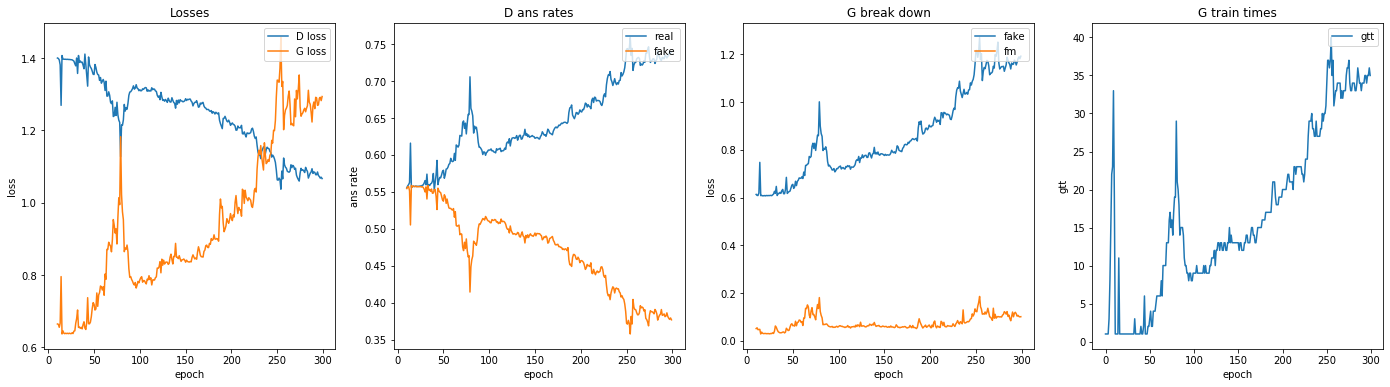

In [18]:
show_status_graph_gan_adaptive(status_dict, holizon=True, burn_in=10)

3 images found in ../datasets/theorytab/midinet/learning/midinet_double_sa
0: fake_samples_epoch100.png
1: fake_samples_epoch200.png
2: fake_samples_epoch300.png
input the number of image:2


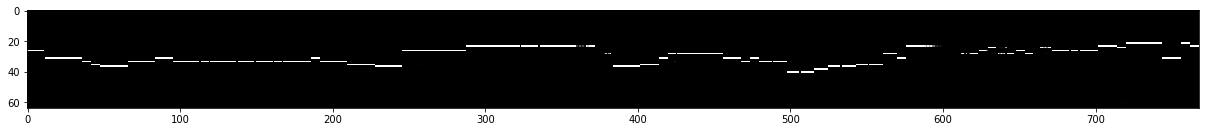

In [21]:
image_paths = glob.glob(os.path.join(save_dir, "fake_samples_*"))
image_paths.sort()

print(f"{len(image_paths)} images found in {save_dir}")
for i, path in enumerate(image_paths):
    print(f"{i}: {path.split('/')[-1]}")

image_path = image_paths[int(input("input the number of image:"))]

img = np.array(Image.open(image_path))
fig, ax = plt.subplots(figsize=(21, 7))
ax.imshow(img)